# Dextra Weather

## Gabriel Moreira

In [447]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow as tf
from pylab import rcParams
rcParams['figure.figsize'] = 22, 10
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error

## Análise dos dados

In [448]:
# read data from csv
df = pd.read_csv('./Summary of Weather.csv')
df_locations = pd.read_csv('./Weather Station Locations.csv')

C:\Users\Gabriel\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,8,18,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [449]:
df.head()

,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-7-1,1.016,NaN,25.555556,22.222222,23.888889,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-7-2,0,NaN,28.888889,21.666667,25.555556,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-7-3,2.54,NaN,26.111111,22.222222,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-7-4,2.54,NaN,26.666667,22.222222,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-7-5,0,NaN,26.666667,21.666667,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [450]:
df_locations.head()

,WBAN,NAME,STATE/COUNTRY ID,LAT,LON,ELEV,Latitude,Longitude
0,33013,AIN EL,AL,3623N,00637E,611,36.383333,6.650000
1,33031,LA SENIA,AL,3537N,00037E,88,35.616667,0.583333
2,33023,MAISON BLANCHE,AL,3643N,00314E,23,36.716667,3.216667
3,33044,TELERGMA,AL,3607N,00621E,754,36.116667,6.416667
4,12001,TINDOUF,AL,2741N,00809W,443,27.683333,-8.083333


In [451]:
# fazer um merge nos dois datasets 
df_locations['STA'] = df_locations['WBAN']
df = pd.merge(df_locations, df, on='STA')
df.head()

,WBAN,NAME,STATE/COUNTRY ID,LAT,LON,ELEV,Latitude,Longitude,STA,Date,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,33013,AIN EL,AL,3623N,00637E,611,36.383333,6.65,33013,1943-3-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33013,AIN EL,AL,3623N,00637E,611,36.383333,6.65,33013,1943-3-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,33013,AIN EL,AL,3623N,00637E,611,36.383333,6.65,33013,1943-3-13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,33013,AIN EL,AL,3623N,00637E,611,36.383333,6.65,33013,1943-3-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,33013,AIN EL,AL,3623N,00637E,611,36.383333,6.65,33013,1943-3-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [452]:
# calculo da amplitude termica
df['DiffTemp'] = df['MaxTemp'] - df['MinTemp']
# estou buscando um estado/país cuja amplitude térmica não seja tão baixa, para deixar os cálculos mais interessantes,
# mas ao mesmo tempo devo ter um número de data points considerável

# selecionar dados do estado com o maior número de data points
# afinal cada estação (STA) possui uma latitude e longitude diferente, o que pode mudar nosso modelo

data_poins_per_state = df.groupby('STATE/COUNTRY ID')['STA'].count()
temp_diff_per_state = df.groupby('STATE/COUNTRY ID')['DiffTemp'].mean()

# filtrar estados com data points > 6000
data_poins_per_state = dict(filter(lambda elem: elem[1] > 6000, data_poins_per_state.items()))

# filtrar estados com amplitude térmica > 10 graus
temp_diff_per_state = dict(filter(lambda elem: elem[1] > 10, temp_diff_per_state.items()))

# interseccao entre os dois dicionários para pegar o estado ideal
state = set(temp_diff_per_state.keys()).intersection(set(data_poins_per_state.keys()))
state = list(state)[0]
print(f'Estado escolhido: {state}')

Estado escolhido: IN


In [453]:
df = df[df['STATE/COUNTRY ID'] == state]

In [454]:
# extract better columns

df = df[['Date', 'Precip', 'MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall', 'DiffTemp']]

# transform Date to datetime object
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Precip,MaxTemp,MinTemp,MeanTemp,Snowfall,DiffTemp
56576,1942-08-24,0,32.222222,25.000000,28.888889,0,7.222222
56577,1942-08-25,9.652,31.111111,25.555556,28.333333,0,5.555556
56578,1942-08-26,0.762,32.222222,25.000000,28.888889,0,7.222222
56579,1942-08-27,19.558,32.222222,24.444444,28.333333,0,7.777778
56580,1942-08-28,2.54,31.666667,25.555556,28.888889,0,6.111111


In [455]:
df.describe()

,MaxTemp,MinTemp,MeanTemp,DiffTemp
count,9530.000000,9530.000000,9530.000000,9530.000000
mean,31.113326,19.005596,25.020462,12.107730
std,5.976057,6.206429,5.801792,4.957049
min,-17.777778,-17.777778,-17.777778,-43.333333
25%,27.777778,14.444444,21.111111,8.888889
50%,31.111111,19.444444,25.555556,12.222222
75%,34.444444,24.444444,28.888889,15.555556
max,48.333333,34.444444,40.000000,50.555556


In [456]:
df.corr()

,MaxTemp,MinTemp,MeanTemp,DiffTemp
MaxTemp,1.000000,0.669462,0.928207,0.367373
MinTemp,0.669462,1.000000,0.879693,-0.444959
MeanTemp,0.928207,0.879693,1.000000,0.017604
DiffTemp,0.367373,-0.444959,0.017604,1.000000


As correlações entre temperatura média e a temperatura máxima é maior que a correlação entre a temperatura mínima e temperatura máxima

In [457]:
# check NaN values
df.isnull().sum()

Date        0
Precip      0
MaxTemp     0
MinTemp     0
MeanTemp    0
Snowfall    4
DiffTemp    0
dtype: int64

In [458]:
COLORS = ['green', 'red', 'blue']

In [459]:
df = df.drop(['Snowfall'], axis=1)

MeanTemp mean: 25.020461700041867
MeanTemp std: 5.80179249010336 

MaxTemp mean: 31.113326337866738
MaxTemp std: 5.976057466464003 

MinTemp mean: 19.00559636232183
MinTemp std: 6.206428673068687 



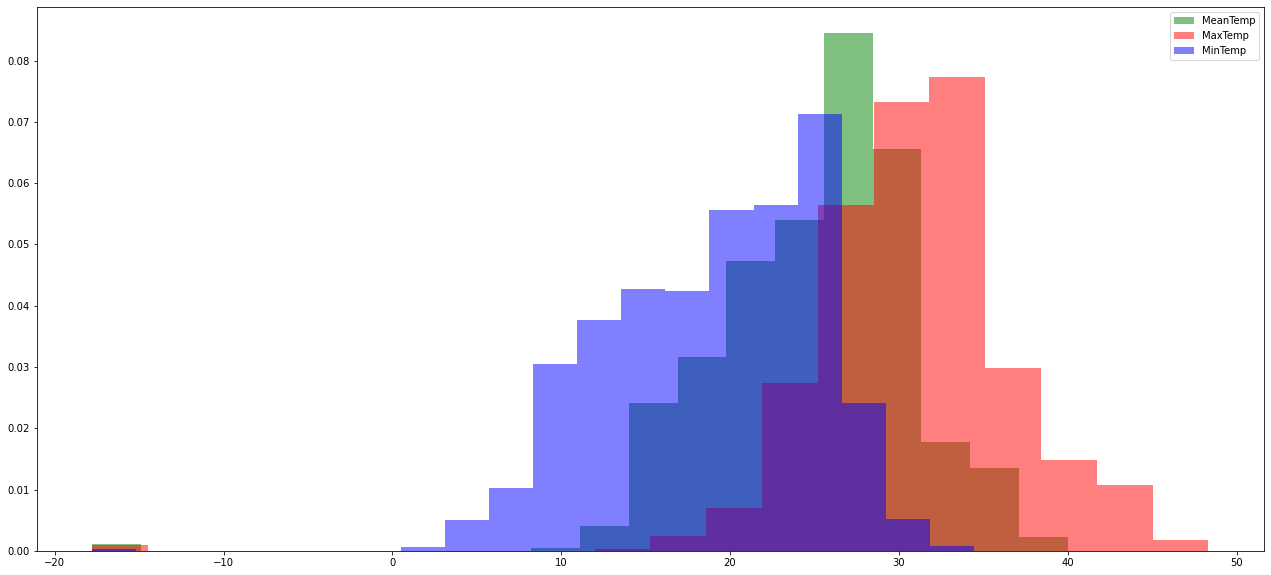

In [460]:
import scipy.stats
normal_tags = ['MeanTemp', 'MaxTemp', 'MinTemp']
for i, normal_tag in enumerate(normal_tags):
    mean = df[normal_tag].mean()
    std = df[normal_tag].std()
    print(f'{normal_tag} mean: {mean}')
    print(f'{normal_tag} std: {std} \n')

    plt.hist(df[normal_tag], alpha=.5, bins=20, label=normal_tag, color=COLORS[i], density=1)
plt.legend()
plt.show()


Vale notar que as variáveis relativas à temperatura possuem um desvio padrão muito parecido. E ficou claro também a presença de um outlier na parte esquerda do histograma.

In [461]:
# retirar outlier que pode atrapalhar no modelo
df = df[df['MaxTemp'] > 0]

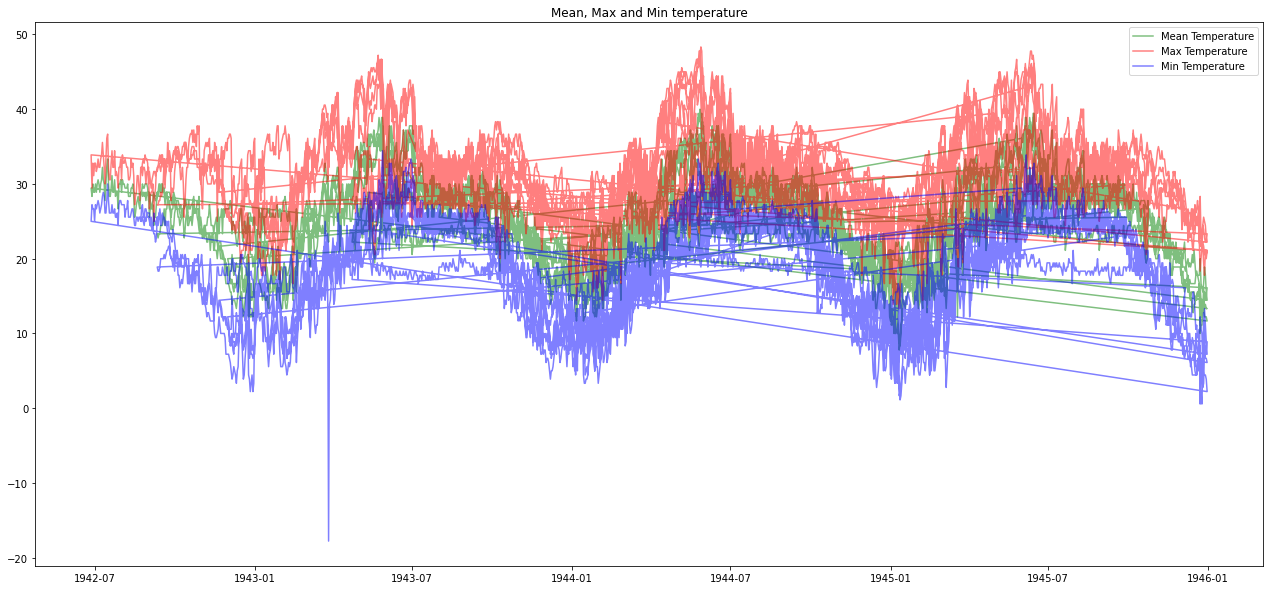

In [462]:
# plt.figure(figsize=(22,10))
plt.title('Mean, Max and Min temperature')
plt.plot(df['Date'], df['MeanTemp'], color='green', alpha=.5, label='Mean Temperature')
plt.plot(df['Date'], df['MaxTemp'], color='red', alpha=.5, label='Max Temperature')
plt.plot(df['Date'], df['MinTemp'], color='blue', alpha=.5, label='Min Temperature')
plt.legend()
plt.show()

In [463]:
# busco saber a influencia da chuva na amplitude termica

# calculo da amplitude termica
df = df.replace('T', np.nan)

df['Rained'] = df['Precip'].apply(lambda x: float(x)) > 0
print(f'Max diff: {max(df["DiffTemp"])}')
print(f'Min diff: {min(df["DiffTemp"])}')

Max diff: 50.55555556
Min diff: 1.1111111099999995


Vou limpar os dados visto que a amplitude não pode ser de 50 graus.

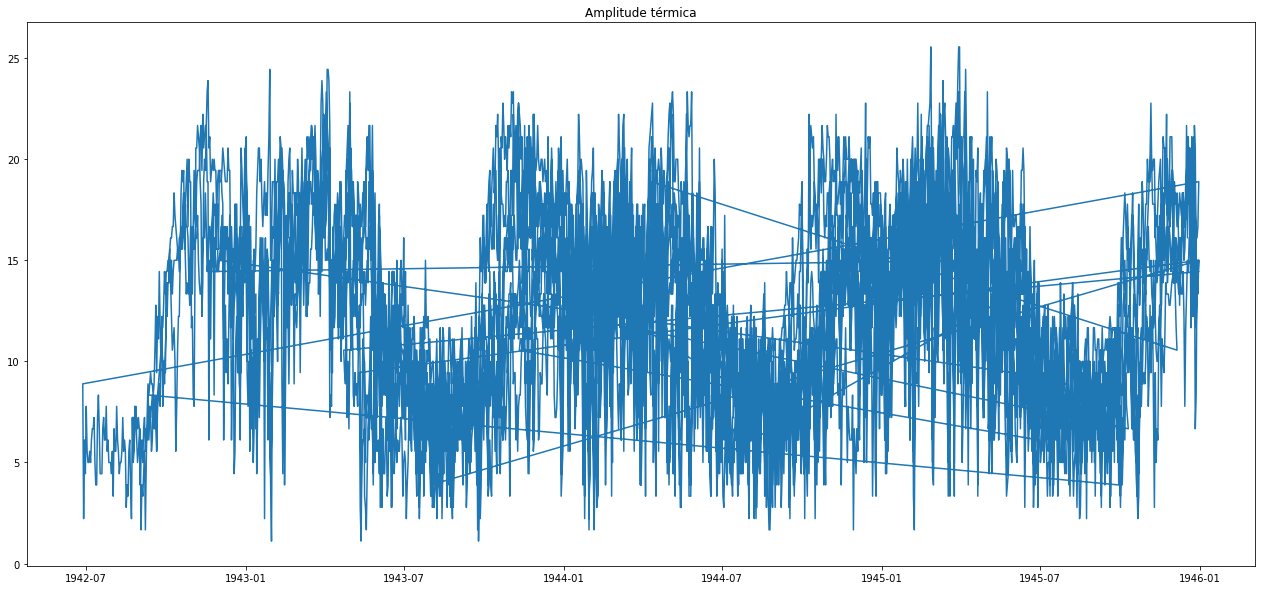

In [464]:
df = df[(abs(df['DiffTemp']) < 30)]
plt.title('Amplitude térmica')
plt.plot(df['Date'], df['DiffTemp'])

In [465]:
print(f'Média da amplitude da temperatura nos dias que choveu: {df[df["Rained"]]["DiffTemp"].mean()} graus')
print(f'Média da temperatura nos dias que choveu: {df[df["Rained"]]["MeanTemp"].mean()} graus')

print(f'Desvio padrão da amplitude da temperatura nos dias que choveu: {df[df["Rained"]]["DiffTemp"].std()} graus \n')

print(f'Média da amplitude da temperatura nos dias que não choveu: {df[~df["Rained"]]["DiffTemp"].mean()} graus')
print(f'Média da temperatura nos dias que não choveu: {df[~df["Rained"]]["MeanTemp"].mean()} graus')

print(f'Desvio padrão da amplitude da temperatura nos dias que não choveu: {df[~df["Rained"]]["DiffTemp"].std()} graus')

Média da amplitude da temperatura nos dias que choveu: 8.35672979322209 graus
Média da temperatura nos dias que choveu: 26.162539178347238 graus
Desvio padrão da amplitude da temperatura nos dias que choveu: 3.1644712952524157 graus 

Média da amplitude da temperatura nos dias que não choveu: 13.610753098751681 graus
Média da temperatura nos dias que não choveu: 24.786942893154663 graus
Desvio padrão da amplitude da temperatura nos dias que não choveu: 3.9265799717662313 graus


Aparentemente a temperatura se mantem mais constante nos dias que chovem, visto que a amplitude térmica é menor. Os dias que chovem também são ligeiramente mais frios.

## Previsão da temperatura máxima dada a temperatura média

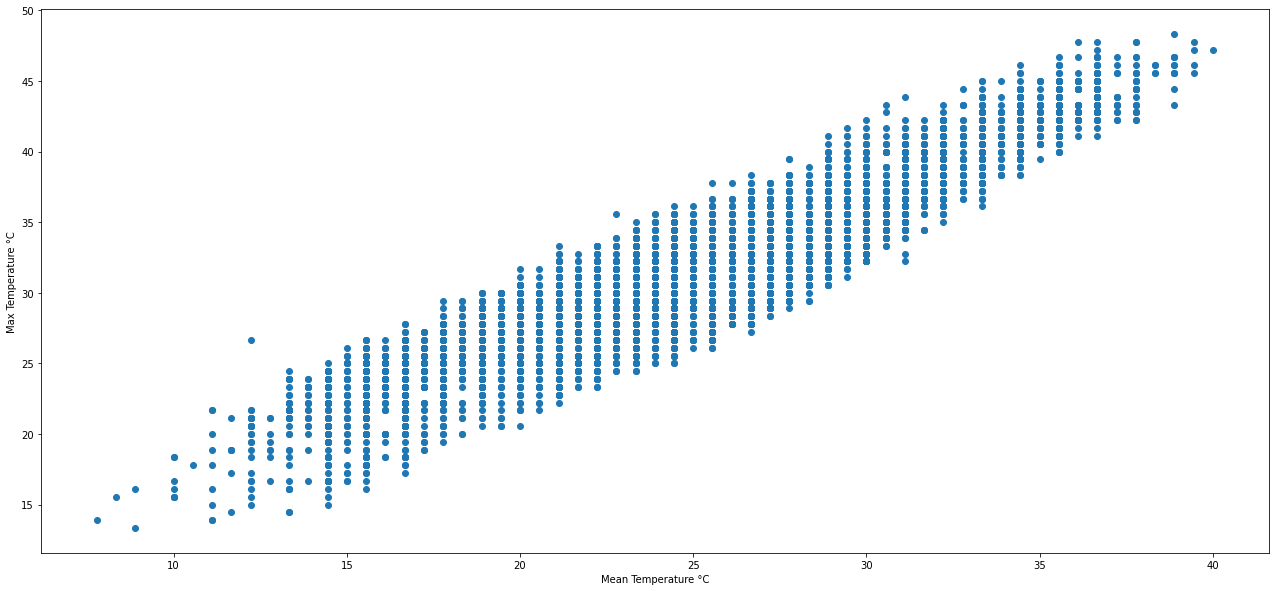

In [466]:
plt.scatter(df['MeanTemp'], df['MaxTemp'])
plt.xlabel('Mean Temperature °C')
plt.ylabel('Max Temperature °C')
plt.show()

In [467]:
# separação dos dados entre treino e teste
y = np.array(df['MaxTemp']).reshape(-1, 1)
X = np.array(df['MeanTemp']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

### Linear Regression

In [468]:

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

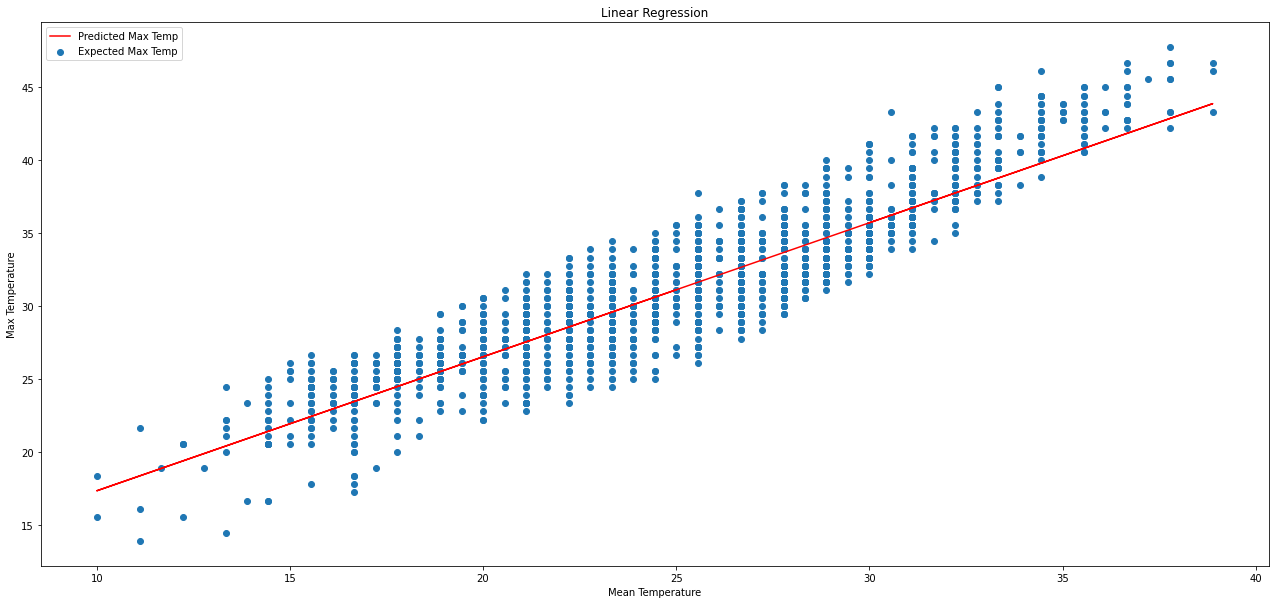

RMSE: 2.2023996245211244


In [469]:
# plt.scatter(X_train, y_train, color="red")
plt.plot(X_test, lr.predict(X_test), color="red", label='Predicted Max Temp')
plt.scatter(X_test, y_test, label='Expected Max Temp')
plt.xlabel("Mean Temperature")
plt.ylabel("Max Temperature")
plt.title("Linear Regression")
plt.legend()
plt.show()
print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test)) ** (1/2)}')

### Decision Tree Regressor

In [470]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=42)
regressor = regressor.fit(X_train, y_train)

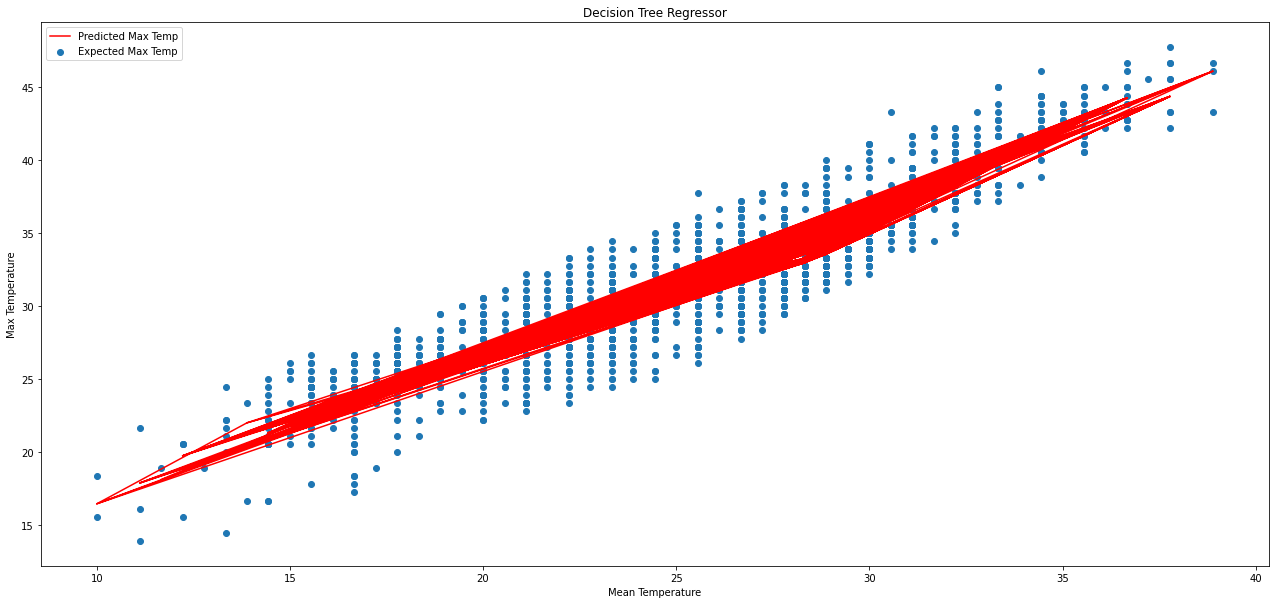

RMSE: 2.075679377245591


In [471]:
plt.plot(X_test, regressor.predict(X_test), color="red", label='Predicted Max Temp')
plt.scatter(X_test, y_test, label='Expected Max Temp')
plt.xlabel("Mean Temperature")
plt.ylabel("Max Temperature")
plt.title("Decision Tree Regressor")
plt.legend()
plt.show()
print(f'RMSE: {mean_squared_error(y_test, regressor.predict(X_test)) ** (1/2)}')

### Random Forest Regressor

In [472]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=10, random_state=42)
rf_reg.fit(X_train, y_train)

C:\Users\Gabriel\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(n_estimators=10, random_state=42)

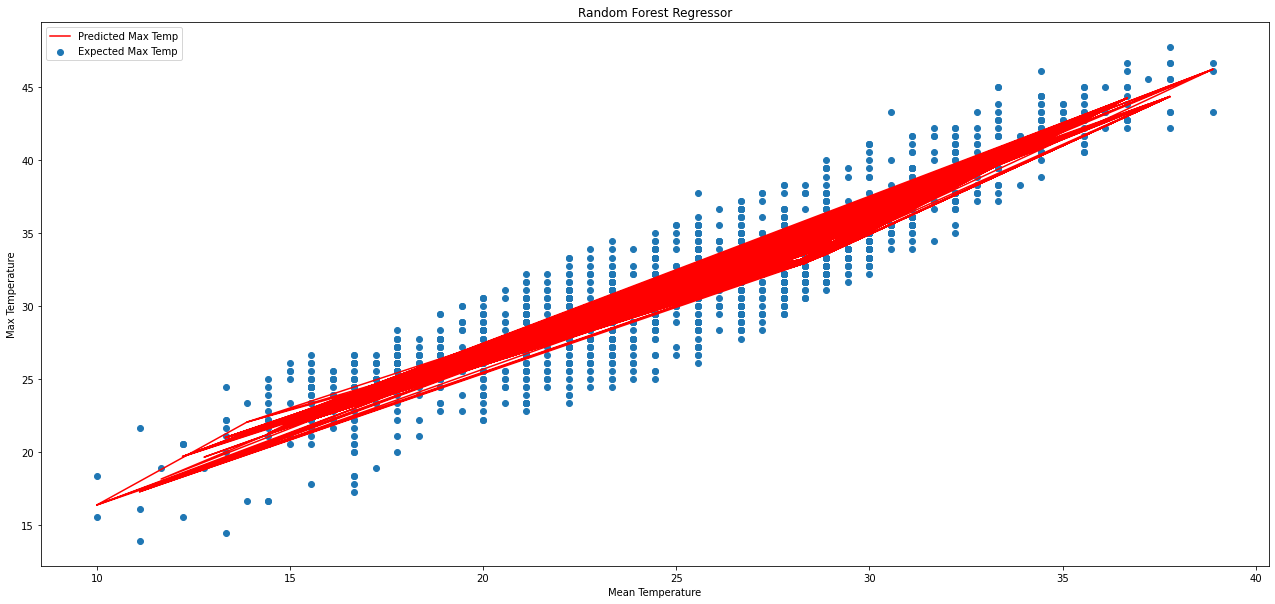

RMSE: 2.0748564744632354


In [473]:
plt.plot(X_test, rf_reg.predict(X_test), color="red", label='Predicted Max Temp')
plt.scatter(X_test, y_test, label='Expected Max Temp')
plt.xlabel("Mean Temperature")
plt.ylabel("Max Temperature")
plt.title("Random Forest Regressor")
plt.legend()
plt.show()
print(f'RMSE: {mean_squared_error(y_test, rf_reg.predict(X_test)) ** (1/2)}')

### Support Vector Regression

In [474]:
from sklearn.svm import SVR
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr = svr.fit(X_train, y_train)

C:\Users\Gabriel\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


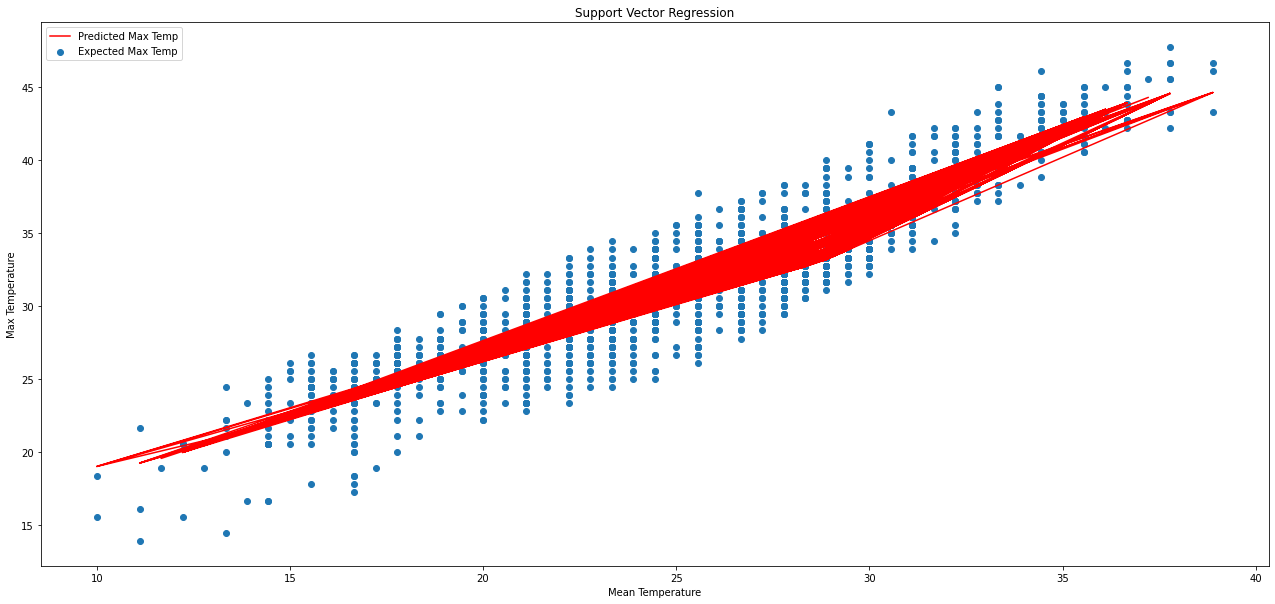

RMSE: 2.10115184653158


In [475]:
plt.plot(X_test, regr.predict(X_test), color="red", label='Predicted Max Temp')
plt.scatter(X_test, y_test, label='Expected Max Temp')
plt.xlabel("Mean Temperature")
plt.ylabel("Max Temperature")
plt.title("Support Vector Regression")
plt.legend()
plt.show()
print(f'RMSE: {mean_squared_error(y_test, regr.predict(X_test)) ** (1/2)}')

### O melhor modelo, segundo a métrica de RMSE foi o Random Forest Regressor com um RMSE de 2.07485, ligeiramente à frente do modelo de Decision Tree.